# Explainable Machine Learning

## Preprocessing

### Loading the dataset

In [1]:
import pandas as pd
import os

In [2]:
df_sms = pd.read_csv('spam_data.csv', encoding='latin-1')
df_sms.dropna(axis=1, inplace=True)
df_sms.columns = ['label', 'message']
df_sms

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df_sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [4]:
df_sms['label'] = df_sms.label.map({'ham':0, 'spam':1})

### Tokenization

In [5]:
import gensim
import nltk

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ceyx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def tokenize(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(stemmer.stem(lemmatizer.lemmatize(token,'v')))
    return result

In [7]:
messages = df_sms['message'].map(tokenize)

### Bag-of-Words & TfIdf

In [8]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

In [9]:
dictionary = Dictionary(messages)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in messages]

In [11]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]
tfidf_corpus = corpus2dense(tfidf_corpus, num_terms=len(dictionary.token2id), num_docs=len(tfidf_corpus)).T

## Explainable Machine Learning algorithms

### White-box models

In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [13]:
x = tfidf_corpus
y = df_sms['label']
feature_names = dictionary.token2id.keys()
target_names = ['ham', 'spam']
x_train, x_test, y_train, y_test = train_test_split(x, y)

#### Logistic Regression

In [14]:
log_reg = LogisticRegression(max_iter=1000, C=100)
log_reg.fit(x_train, y_train)

LogisticRegression(C=100, max_iter=1000)

In [15]:
y_predicted_train = log_reg.predict(x_train)
y_predicted_test = log_reg.predict(x_test)
y_predicted_proba_test = log_reg.predict_proba(x_test)

In [16]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1197
        spam       0.99      0.88      0.93       196

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [17]:
weights = log_reg.coef_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights[0]})
model_weights = model_weights.iloc[model_weights.weights.abs().argsort()[::-1]]
model_weights = model_weights[model_weights.weights.abs() > 1]
print("Number of words with an absolute weight higher than 1:", len(model_weights))
print("Logistic regression intercept:", log_reg.intercept_[0])
plt.figure(figsize=(200,150), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x='weights', y='features', data=model_weights)
plt.show()

Number of words with an absolute weight higher than 1: 686
Logistic regression intercept: -5.688760055731137


#### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [19]:
tree_clf = DecisionTreeClassifier(max_depth=30)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [20]:
y_predicted_train = tree_clf.predict(x_train)
y_predicted_test = tree_clf.predict(x_test)
y_predicted_proba_test = tree_clf.predict_proba(x_test)

In [21]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1197
        spam       0.91      0.84      0.87       196

    accuracy                           0.97      1393
   macro avg       0.94      0.91      0.93      1393
weighted avg       0.96      0.97      0.96      1393



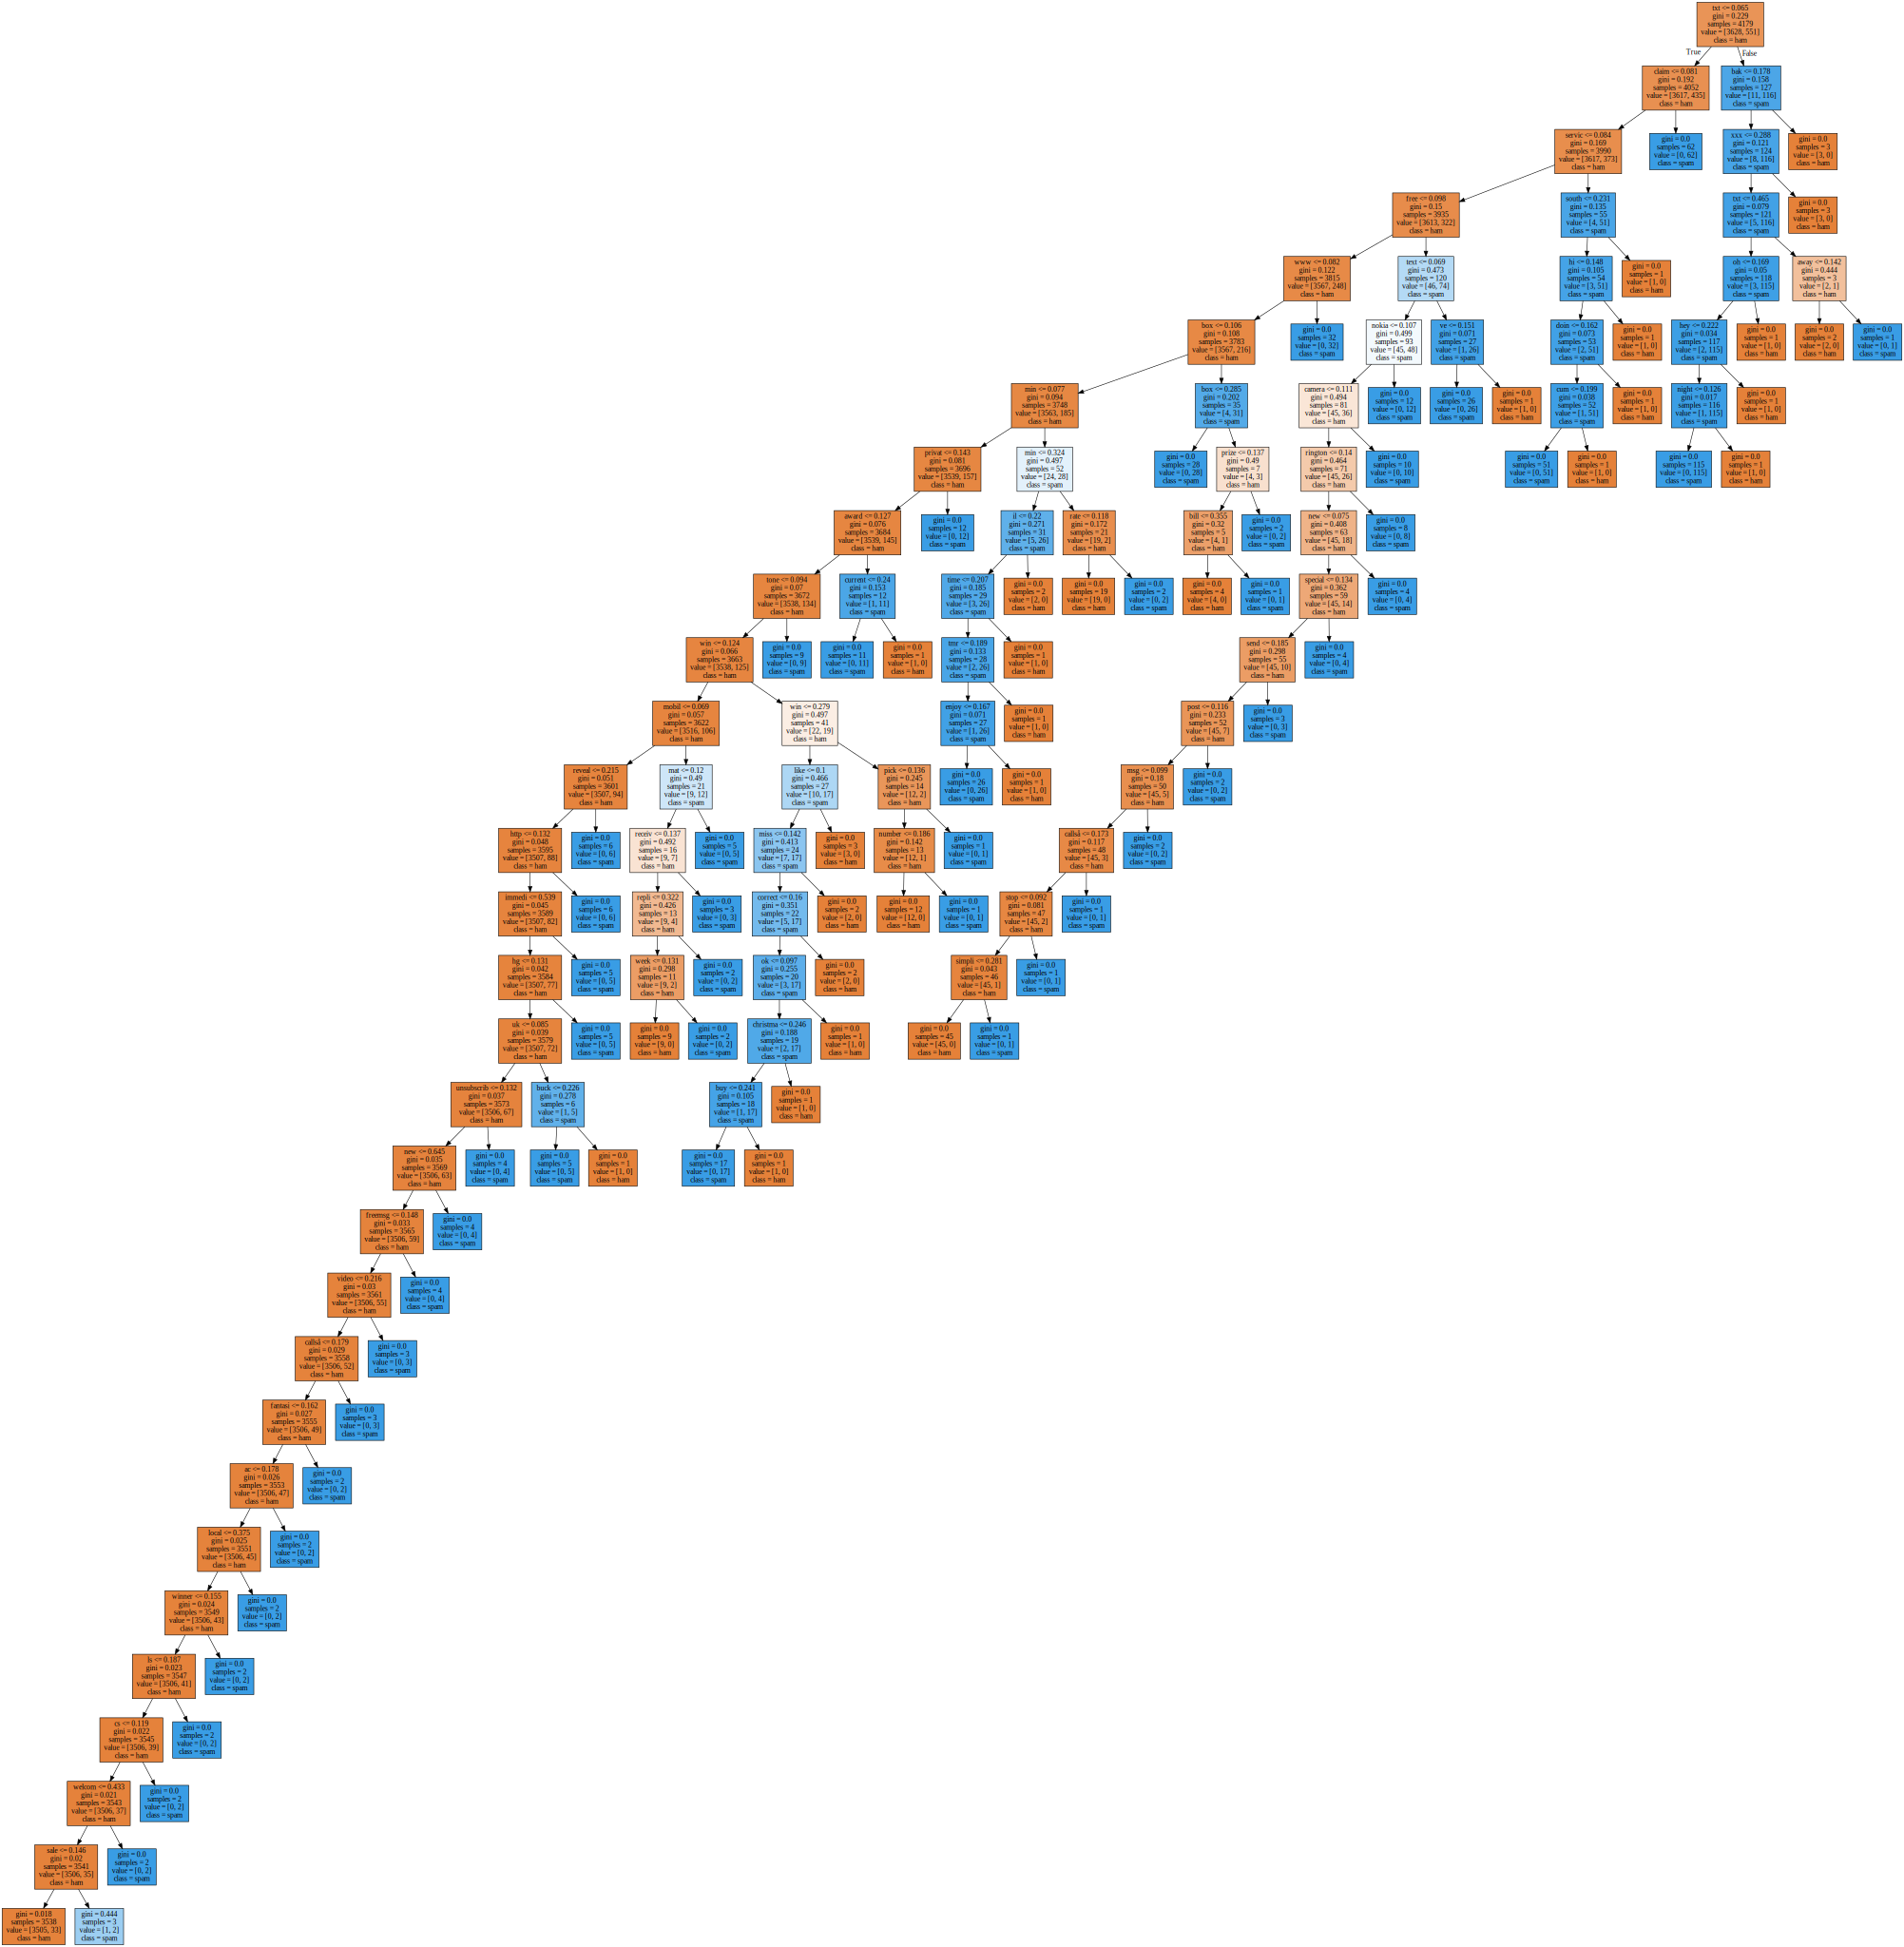

In [22]:
SVG(Source(
    export_graphviz(tree_clf, 
                    feature_names=list(feature_names), 
                    class_names=target_names, 
                    filled=True)
    ).pipe(format='svg')
   )

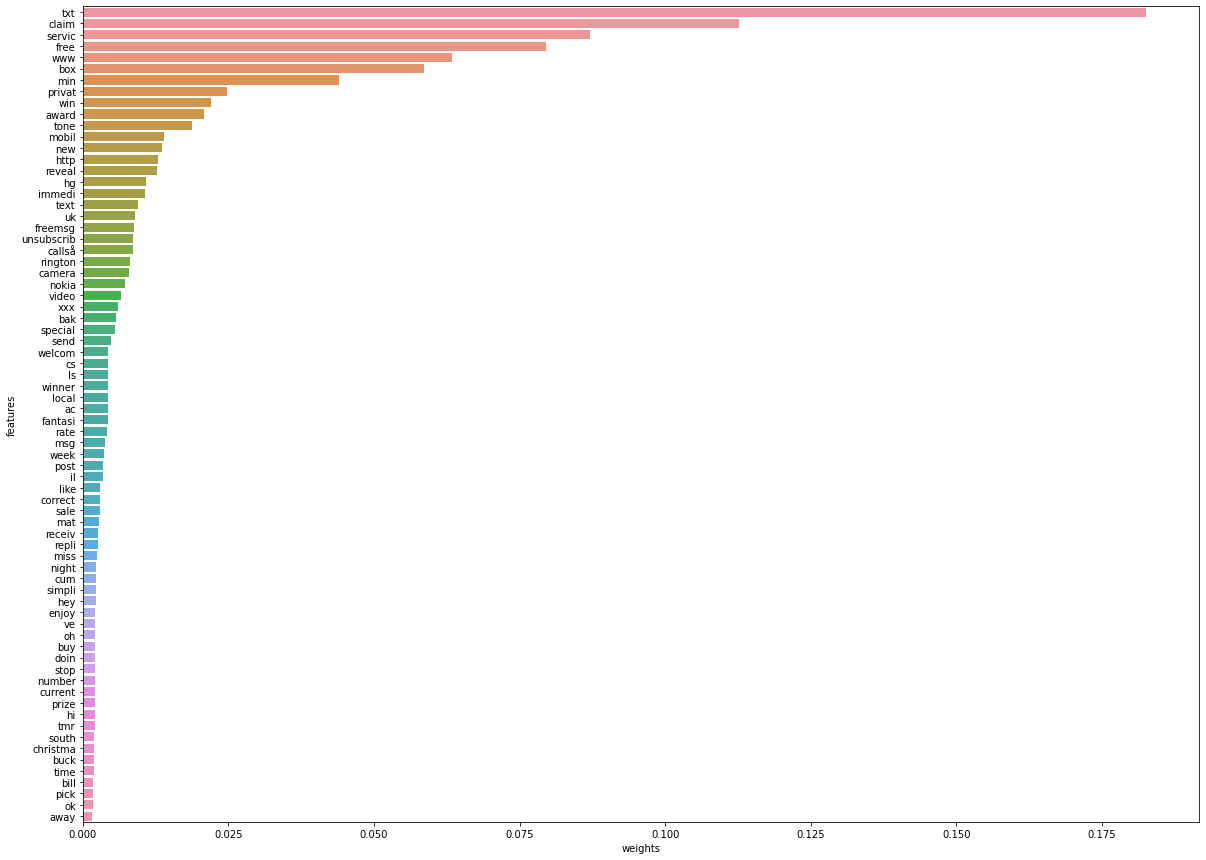

In [23]:
weights = tree_clf.feature_importances_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights})
model_weights = model_weights.sort_values('weights', ascending=False)
model_weights = model_weights[model_weights.weights > 0]
plt.figure(figsize=(20,15), facecolor='w', edgecolor='k')
sns.barplot(x='weights', y='features', data=model_weights);

### Black-box model interpretation - Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

In [26]:
y_predicted_test = rf_clf.predict(x_test)

In [27]:
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1197
        spam       1.00      0.87      0.93       196

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [28]:
new_x_train = x_train
new_y_train = rf_clf.predict(x_train)

#### Global surrogate model - Logistic Regression

In [29]:
log_reg_surrogate = LogisticRegression(max_iter=1000, C=100)
log_reg_surrogate.fit(new_x_train, new_y_train)

LogisticRegression(C=100, max_iter=1000)

In [30]:
y_surrogate_pred_test = log_reg_surrogate.predict(x_test)
print("Fidelity:", metrics.accuracy_score(y_predicted_test, y_surrogate_pred_test))
print("Accuracy:", metrics.accuracy_score(y_test, y_surrogate_pred_test))

Fidelity: 0.9877961234745154
Accuracy: 0.9827709978463748


In [31]:
weights = log_reg_surrogate.coef_
model_weights = pd.DataFrame({'features':feature_names, 'weights':weights[0]})
model_weights = model_weights.iloc[model_weights.weights.abs().argsort()[::-1]]
model_weights = model_weights[model_weights.weights.abs() > 1]
print("Number of words with an absolute weight higher than 1:", len(model_weights))
print("Global surrogate logistic regression intercept:", log_reg.intercept_[0])
plt.figure(figsize=(200,150), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x='weights', y='features', data=model_weights)
plt.show()

Number of words with an absolute weight higher than 1: 645
Global surrogate logistic regression intercept: -5.688760055731137


#### Local surrogate model - Decision Tree

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors=100, weights='distance')
knn_clf.fit(new_x_train, new_y_train)

KNeighborsClassifier(n_neighbors=100, weights='distance')

In [34]:
test_instance = [x_test[1391]]
instance_y = knn_clf.kneighbors(test_instance, n_neighbors=100, return_distance=False)

In [35]:
new_x_train2, new_y_train2 = [], []
for i in instance_y[0]:
    new_x_train2.append(new_x_train[i])
    new_y_train2.append(new_y_train[i])

In [36]:
decision_tree_surrogate = DecisionTreeClassifier(max_depth=30)
decision_tree_surrogate.fit(new_x_train2, new_y_train2)

DecisionTreeClassifier(max_depth=30)

In [37]:
y_surrogate_pred_test = log_reg_surrogate.predict(new_x_train2)
print("Fidelity:", metrics.accuracy_score(new_y_train2, y_surrogate_pred_test))

Fidelity: 1.0


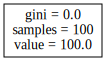

In [38]:
SVG(Source(
    export_graphviz(decision_tree_surrogate, 
                    feature_names=list(feature_names), 
                    class_names=target_names, 
                    filled=True)
    ).pipe(format='svg')
   )

### Variable importance - Permutation importance

In [39]:
import eli5
from eli5.sklearn import PermutationImportance

In [40]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [41]:
y_predicted_test = log_reg.predict(x_test)
print(metrics.classification_report(y_test, y_predicted_test, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1197
        spam       1.00      0.78      0.88       196

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [42]:
importance = PermutationImportance(log_reg).fit(x_test, y_test)
eli5.show_weights(importance, feature_names=list(feature_names))

Weight,Feature
0.0062 ± 0.0015,txt
0.0045 ± 0.0014,free
0.0037 ± 0.0014,win
0.0034 ± 0.0017,text
0.0034 ± 0.0006,uk
0.0032 ± 0.0019,stop
0.0027 ± 0.0006,www
0.0026 ± 0.0007,repli
0.0026 ± 0.0011,contact
0.0026 ± 0.0011,chat
